In [1]:
!pip install stopwords
!git clone https://github.com/jaeniboy/nlp-genres.git

Cloning into 'nlp-genres'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 94 (delta 4), reused 7 (delta 2), pack-reused 81 (from 1)
Receiving objects: 100% (94/94), 33.37 MiB | 9.00 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [10]:
import pandas as pd
import numpy as np
import re
import string
import stopwords
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

In [ ]:
df = pd.read_json("nlp-genres/testset.json")

In [ ]:
# unpack genre lists
def unlist_genre(genre):
  if len(genre) > 0:
    return genre[0]
  else:
    return ""

df["gattung"] = df["gattung"].apply(unlist_genre)

Die fehlende Gattung ist ein Statement, das wird hier korrigiert

In [ ]:
index = df[df["gattung"] == ""].index.tolist()
df.loc[index,["gattung"]] = "Statement"
df[df["gattung"] == ""]

,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink


In [ ]:
balance_counts = df.groupby("gattung")["gattung"].agg("count")
balance_counts

,gattung
gattung,
Bericht,194
Bericht in Interviewform,200
Glosse,191
Interview,182
Reportage,198
Statement,201
Umfrage,195



Hier werden einfach nur Dinge gezählt:

In [ ]:
def word_count(text):
    return len(text.split(" "))

def char_count(text):
    return len(text)

def avr_sentence_length(text):
    sentences = text.split(".")
    lengths = [len(sentence) for sentence in sentences]
    mean = np.asarray(lengths).mean().round(2)
    return mean

df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)

In [ ]:
def plot_count_by_category(char_count_by_category, count_label):
    plt.figure(figsize=(6, 4))
    #plt.figure(figsize=(10, 6))
    char_count_by_category.plot(kind='bar', color='skyblue')
    plt.title(f'{count_label} pro Gattung')
    plt.xlabel('Gattung')
    plt.ylabel(count_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

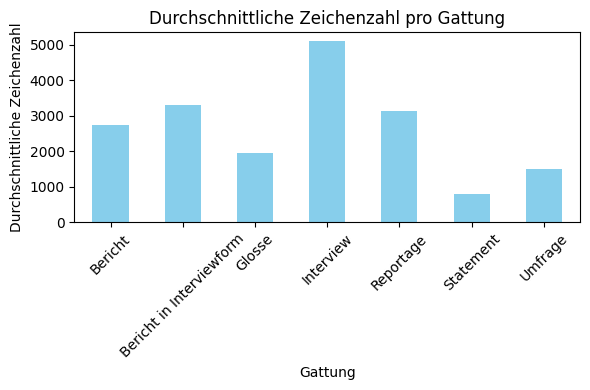

In [ ]:
char_count_by_category = df.groupby("gattung")["char_count"].agg("mean").round(0)
plot_count_by_category(char_count_by_category, "Durchschnittliche Zeichenzahl")

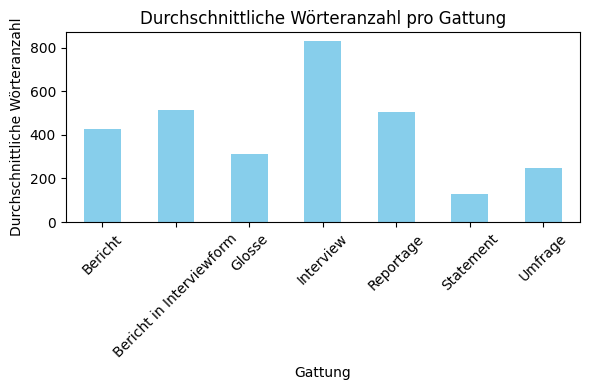

In [ ]:
word_count_by_category = df.groupby("gattung")["word_count"].agg("mean").round(0)
plot_count_by_category(word_count_by_category, "Durchschnittliche Wörteranzahl")

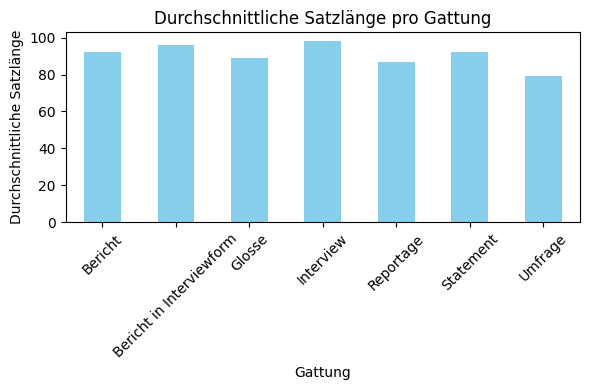

In [ ]:
sentence_length_by_category = df.groupby("gattung")["avr_sentence_length"].agg("mean").round(0)
plot_count_by_category(sentence_length_by_category, "Durchschnittliche Satzlänge")

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'Average sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

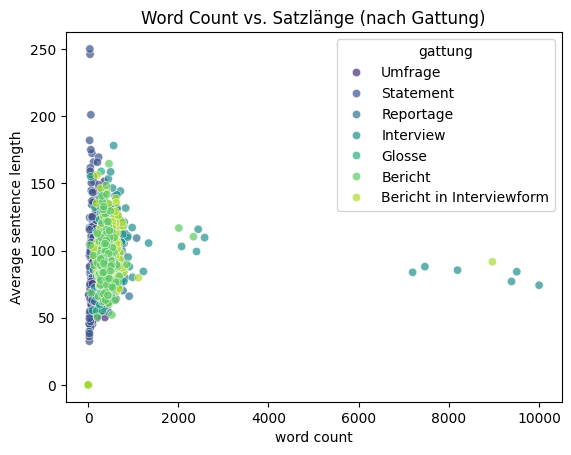

In [ ]:
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="Average sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Hier gibt es einige üble Ausreißer, wie damit umgehen?

1. Kürze das Transcript überlanger Texte auf die Durchschnittslänge der jeweiligen Kategorie

In [ ]:
def truncate_long_text(text, category):
    words = text.split(" ")
    if len(words) < 3000:
        return text
    else:
        return " ".join(words[:word_count_by_category[category].astype(int)])

df["transcript"] = df.apply(lambda row: truncate_long_text(row["transcript"],row["gattung"]), axis=1)
df["word_count"] = df["transcript"].apply(word_count)
df["char_count"] = df["transcript"].apply(char_count)
df["avr_sentence_length"] = df["transcript"].apply(avr_sentence_length)

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

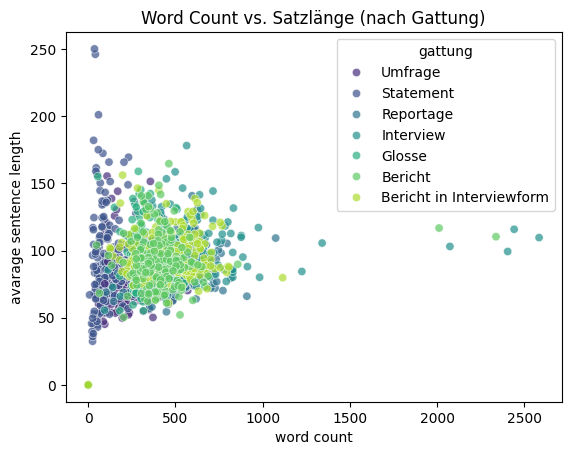

In [ ]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Betrachte die Ausreißer auf der Y-Achse

In [ ]:
df[df["avr_sentence_length"] > 220]

,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink,word_count,char_count,avr_sentence_length
240,241,W3042782#001,(O-Ton) Malaika Mihambo: Olympia-Silber mit At...,(O-Ton) Malaika Mihambo: Olympia-Silber mit At...,"[Silbermedaille, Leistung]",Ich hatte wirklich einfach starke Probleme mit...,"[{'name': 'Mihambo', 'vorname': 'Malaika', 'an...",[],Statement,53054662,https://linkresolver1.ivz.cn.ard.de/linkresolv...,42,246,246.0
334,335,W2841007#003,(O-Ton) Chefarzt: Geisterkrankenhaus,(O-Ton) Chefarzt: Geisterkrankenhaus,[],Jetzt haben wir einen Geisterkrankenhaus daste...,"[{'name': 'Esten', 'vorname': 'Christoph', 'an...","[{'name': 'Pläcking', 'vorname': 'Constantin',...",Statement,52563801,https://linkresolver1.ivz.cn.ard.de/linkresolv...,37,250,250.0


In [ ]:
df.iloc[240]["transcript"]

'Ich hatte wirklich einfach starke Probleme mit den Lungen und von daher bin ich unheimlich stolz auf meine Leistung, weil ich denke, das muss erst mal jemand schaffen, so gehandicapt an den Start zu gehen und dann noch eine Silbermedaille da raus'

Liegt vermutlich am vermehrten Rauschen im Transkript von Statement (keine geübten Sprecher*innen). Ich lasse es erstmal so.

In [ ]:
small_sentence_length = df[df["avr_sentence_length"] < 25]
small_sentence_length.head()

,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink,word_count,char_count,avr_sentence_length
227,228,W2897936#012,Flirten auf Moselfränkisch,Flirten auf Moselfränkisch,[],,"[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Krisam', 'vorname': 'Andreas', 'anm...",Statement,52700965,https://linkresolver1.ivz.cn.ard.de/linkresolv...,1,0,0.0
228,229,W2901663#005,"(O-Ton) Niklas Kaul: Mein ""Bester schlechter Z...","(O-Ton) Niklas Kaul: Mein ""Bester schlechter Z...",[],,"[{'name': 'Kaul', 'vorname': 'Niklas', 'anmerk...",[],Statement,52741164,https://linkresolver1.ivz.cn.ard.de/linkresolv...,1,0,0.0
255,256,W2896700#003,Pfälzerwald-Verein wieder im Aufwind,Pfälzerwald-Verein wieder im Aufwind,[],,"[{'name': 'Bilic', 'vorname': 'Florian', 'anme...",[],Statement,52686368,https://linkresolver1.ivz.cn.ard.de/linkresolv...,1,0,0.0
626,627,W3268633#002,Palästinenserhilfen immer schwieriger. Telefon...,Palästinenserhilfen immer schwieriger. Telefon...,[],,"[{'name': 'Klose-Zuber', 'vorname': 'Thorsten'...",[],Interview,53544940,https://linkresolver1.ivz.cn.ard.de/linkresolv...,1,0,0.0
628,629,W3204221#002,Waldbesitzer zur Situation 2024 und Klimawande...,Waldbesitzer zur Situation 2024 und Klimawande...,[],,"[{'name': 'Kurth', 'vorname': 'Jürgen', 'anmer...",[],Interview,53404317,https://linkresolver1.ivz.cn.ard.de/linkresolv...,1,0,0.0


Hier liegen die Dinge ohne Mining-Transkript. Die müssen entfernt werden:

In [ ]:
df = df.drop(small_sentence_length.index).copy()
df.shape

(1343, 14)

[Text(0.5, 0, 'word count'),
 Text(0, 0.5, 'avarage sentence length'),
 Text(0.5, 1.0, 'Word Count vs. Satzlänge (nach Gattung)')]

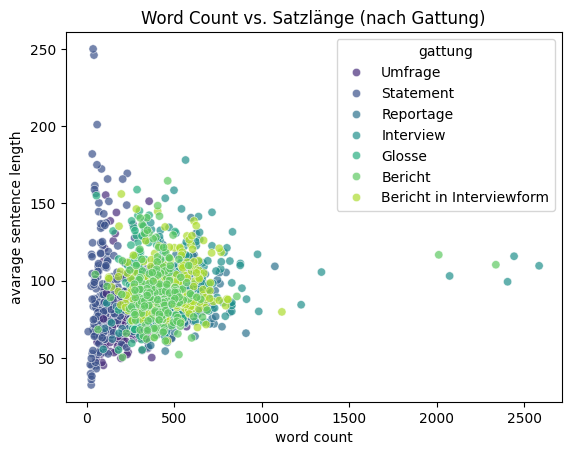

In [ ]:
# Scatterplot mit Seaborn (handhabt Kategorien automatisch)
ax = sns.scatterplot(
    data=df,
    x='word_count',
    y='avr_sentence_length',
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='viridis',
    alpha=0.7
)
ax.set(xlabel="word count", ylabel="avarage sentence length", title='Word Count vs. Satzlänge (nach Gattung)')

Besser! Jetzt das transcript entschlacken

In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub("-"," ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df["clean_text"] = df["transcript"].apply(clean)
df.loc[1]["clean_text"]

'he ute ist weltknuddeltag was es nicht alles gibt weltknuddeltag existiert schon seit 38 jahren und wurde ins leben gerufen und leuten vor augen zu führen wie wichtig so eine kurze umarmung so ein kurzes knuddeln fürs wohlbefinden sein kann unser reporter jens alenia hat nachgehakt und gefragt wann haben sie denn das letzte mal geknuddelt und wen mein mann meine freundin mein freund ist knüller mir von meiner oma mutter vater tante cousine großtante da kommt es ja aus dem knuddel nicht mehr raus das ist auch gut so meine freundin deren mann knuddel ist wie knuddeln den mann ihrer freunde ja natürlich wir sind uns sehr lange vertraute freunde ein bisschen körperkontakt muss schon sein auf jeden fall also schob ein teddybär den ich gern knuddele jeden abend eine bettdecke gibt es irgendeine bekannte persönlichkeit die sie ger ne mal knuddeln würden j taylor swift justin timberlake vielleicht denen würde ich knuddeln ja alle so süß ist ich glaub fremde leute knuddelt ich gar nicht so ger

**Stopwörter entfernen**

In [ ]:
stop_words = stopwords.get_stopwords("de")

def remove_stopwords(text):
    return " ".join([word for word in text.split(" ") if word not in stop_words])

df["text_stopwordless"] = df["clean_text"].apply(remove_stopwords)
df.head()

,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless
0,1,W3203271#001,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,"[Vorsitzend, Klimaschutz, Parteitag, Ideologie...",Vor der letzten Bundestagswahl waren sie absol...,"[{'name': 'Eberhard', 'vorname': 'Thomas', 'an...",[],Umfrage,53400772,https://linkresolver1.ivz.cn.ard.de/linkresolv...,262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...
1,2,W2647484#001,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,"[Seekuh, Teddybär, Persönlichkeit, Nähe, Weltk...","He ute ist Weltknuddeltag, was es nicht alles ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,52146375,https://linkresolver1.ivz.cn.ard.de/linkresolv...,290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...
2,3,W2094478#002,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,[],"47 elf, Grrrls Wasser ja, hat meine Mutter imm...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,50712481,https://linkresolver1.ivz.cn.ard.de/linkresolv...,222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...
3,4,W2266920#002,Stimmung auf dem Wurstmarkt in Bad Dürkheim,Stimmung auf dem Wurstmarkt in Bad Dürkheim,[],"Ja, meint die Atmosphäre. Im Endeffekt gehört ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Lau', 'vorname': 'Nancy', 'anmerkun...",Umfrage,51275843,https://linkresolver1.ivz.cn.ard.de/linkresolv...,115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...
4,5,W2541896#001,"Oh Pannenbaum, die Pannen am Heiligen Abend - ...","Oh Pannenbaum, die Pannen am Heiligen Abend - ...","[Heiligabend, Weihnachten, Christbaum, Familie...","Gestern Abend großes Familienfest, vielleicht ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,51924100,https://linkresolver1.ivz.cn.ard.de/linkresolv...,333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...


**Tokenisieren**

In [ ]:
!python -m spacy download de_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 9.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load('de_core_news_md')

In [ ]:
def tokenize(text):
    doc = nlp(text)
    tokens = [tok.text for tok in doc]
    return tokens

df["tokens"] = df["transcript"].progress_apply(tokenize)

100%|██████████| 1343/1343 [02:42<00:00,  8.26it/s]


,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens
0,1,W3203271#001,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,"[Vorsitzend, Klimaschutz, Parteitag, Ideologie...",Vor der letzten Bundestagswahl waren sie absol...,"[{'name': 'Eberhard', 'vorname': 'Thomas', 'an...",[],Umfrage,53400772,https://linkresolver1.ivz.cn.ard.de/linkresolv...,262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie..."
1,2,W2647484#001,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,"[Seekuh, Teddybär, Persönlichkeit, Nähe, Weltk...","He ute ist Weltknuddeltag, was es nicht alles ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,52146375,https://linkresolver1.ivz.cn.ard.de/linkresolv...,290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic..."
2,3,W2094478#002,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,[],"47 elf, Grrrls Wasser ja, hat meine Mutter imm...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,50712481,https://linkresolver1.ivz.cn.ard.de/linkresolv...,222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine..."
3,4,W2266920#002,Stimmung auf dem Wurstmarkt in Bad Dürkheim,Stimmung auf dem Wurstmarkt in Bad Dürkheim,[],"Ja, meint die Atmosphäre. Im Endeffekt gehört ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Lau', 'vorname': 'Nancy', 'anmerkun...",Umfrage,51275843,https://linkresolver1.ivz.cn.ard.de/linkresolv...,115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe..."
4,5,W2541896#001,"Oh Pannenbaum, die Pannen am Heiligen Abend - ...","Oh Pannenbaum, die Pannen am Heiligen Abend - ...","[Heiligabend, Weihnachten, Christbaum, Familie...","Gestern Abend großes Familienfest, vielleicht ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,51924100,https://linkresolver1.ivz.cn.ard.de/linkresolv...,333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel..."


**Lemmatisieren**

In [ ]:
def lemmatize(text):
     doc = nlp(text)
     return " ".join([x.lemma_ for x in doc])

df["text_lemmatized"] = df["text_stopwordless"].progress_apply(lemmatize)

100%|██████████| 1343/1343 [01:25<00:00, 15.66it/s]


,lfd,id,traegertitel,tracktitel,keywords,transcript,mitwirkende,urheber,gattung,konf_id,permalink,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized
0,1,W3203271#001,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,Umfrage: Grüne Spitze tritt zurück / Voxpop au...,"[Vorsitzend, Klimaschutz, Parteitag, Ideologie...",Vor der letzten Bundestagswahl waren sie absol...,"[{'name': 'Eberhard', 'vorname': 'Thomas', 'an...",[],Umfrage,53400772,https://linkresolver1.ivz.cn.ard.de/linkresolv...,262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,2,W2647484#001,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,Welt-Knuddeltag - Wen haben Sie zuletzt geknud...,"[Seekuh, Teddybär, Persönlichkeit, Nähe, Weltk...","He ute ist Weltknuddeltag, was es nicht alles ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,52146375,https://linkresolver1.ivz.cn.ard.de/linkresolv...,290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,3,W2094478#002,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,Welches Parfüm weckt bei Ihnen Erinnerungen? U...,[],"47 elf, Grrrls Wasser ja, hat meine Mutter imm...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,50712481,https://linkresolver1.ivz.cn.ard.de/linkresolv...,222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,4,W2266920#002,Stimmung auf dem Wurstmarkt in Bad Dürkheim,Stimmung auf dem Wurstmarkt in Bad Dürkheim,[],"Ja, meint die Atmosphäre. Im Endeffekt gehört ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Lau', 'vorname': 'Nancy', 'anmerkun...",Umfrage,51275843,https://linkresolver1.ivz.cn.ard.de/linkresolv...,115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,5,W2541896#001,"Oh Pannenbaum, die Pannen am Heiligen Abend - ...","Oh Pannenbaum, die Pannen am Heiligen Abend - ...","[Heiligabend, Weihnachten, Christbaum, Familie...","Gestern Abend großes Familienfest, vielleicht ...","[{'name': 'N. N.', 'vorname': None, 'anmerkung...","[{'name': 'Alinia', 'vorname': 'Jens', 'anmerk...",Umfrage,51924100,https://linkresolver1.ivz.cn.ard.de/linkresolv...,333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...


**Hier kann man den Dataframe direkt laden, um sich in Zukunft das Preprocessing zu sparen!**

In [3]:
# load dataframe to save time
#try:
#    df.to_pickle("nlp-genres/lemmatized.pkl")
#except:
#    df = pd.read_pickle("nlp-genres/lemmatized.pkl")

df = pd.read_pickle("nlp-genres/lemmatized.pkl")

In [7]:
df

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...
...,...,...,...,...,...,...,...,...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht,"0.046196766197681004, 0.041371896862983, -0.07...",276,1894,93.75,da hüpft ein kleines roboterbein im kreis es s...,hüpft kleines roboterbein kreis sieht känguru ...,"[Da, hüpft, ein, kleines, Roboterbein, im, Kre...",hüpfen klein Roboterbein Kreis sehen Känguru F...
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht,"0.050470415502786005, 0.022042037919163003, -0...",346,2194,90.46,noch ziemlich entspannt muss ich sagen ich kan...,noch ziemlich entspannt muss sagen glaube leug...,"[Noch, ziemlich, entspannt, muss, ich, sagen, ...",noch ziemlich entspannt muss sagen glauben leu...
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht,"0.103638991713523, -0.041198708117008, -0.0684...",437,2638,66.67,seit der hier für die rabattaktion nein bisher...,seit hier rabattaktion bisherigen beschlüsse s...,"[Seit, der, hier, für, die, Rabattaktion, Nein...",seit hier Rabattaktion bisherig Beschluß so ri...
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht,"0.06876039505004801, -0.022558914497494, -0.06...",204,1251,112.82,ich bin leon schäfer 27 jahre alt paar leichta...,leon schäfer 27 jahre alt paar leichtathlet st...,"[Ich, bin, Leon, Schäfer, ,, 27, Jahre, alt, ,...",Leon Schäfer 27 Jahr alt paar Leichtathlet Sta...


## Test verschiedener Modelle

Hier wird ein Bag of Words Ansatz versucht. Es macht einen erheblichen Unterschied, wie der max_features Wert bei der Vektorisierung gewählt wird, auch abhängig vom Modell. Tendenziell zeigt sich, dass die Ergebnisse etwas besser werden, wenn man die Stopwords drin lässt.

**BoW erstellen und mit PCA analysieren:**

In [ ]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

import matplotlib.pyplot as plt

# PCA durchführen (auf 2D reduzieren)
svd = TruncatedSVD(n_components=2, random_state=42)
# pca = PCA(n_components=2)
X_pca = svd.fit_transform(X)  # X_count_vectorized = Ihre transformierten Daten

[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

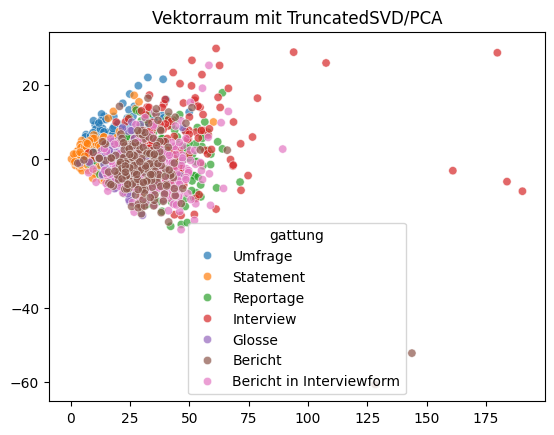

In [ ]:
ax = sns.scatterplot(
    data=df,
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit TruncatedSVD/PCA")

What a mess!

In [ ]:

# t-SNE anwenden (auf 2D reduzieren)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Text(0.5, 1.0, 'Vektorraum mit TruncatedSVD/PCA')]

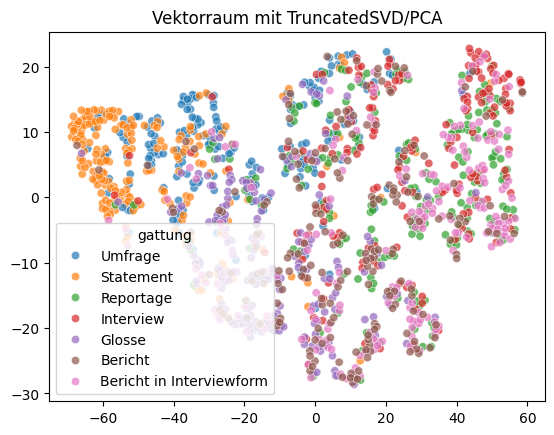

In [ ]:
ax = sns.scatterplot(
    data=df,
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue='gattung',  # Direkte Verwendung der Textkategorien
    palette='tab10',
    alpha=0.7
)
ax.set(title = "Vektorraum mit T-SNE")

Witzig, aber ohne wirkliche Cluster

## Bag of Words

### BoW + Naive Bayes

In [ ]:
vectorizer = CountVectorizer(max_features=4000)

X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9320297951582868
Genauigkeit Testset: 0.5910780669144982


Overfitting!

### BoW + Logistic Regression

In [ ]:

vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6654275092936803


Overfitting!

### BoW + Support Vector Machines

In [ ]:


vectorizer = CountVectorizer(max_features=8000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

# model = SVC(kernel='linear', C=1.0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Genauigkeit: {accuracy}")

Beste Parameter: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.6201117318435755


In [ ]:
model = SVC(C=10, gamma="scale", kernel="rbf")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", model.score(X_train, y_train))
print("Genauigkeit Testset:", model.score(X_test, y_test))

Genauigkeit Trainingsset: 0.9916201117318436
Genauigkeit Testset: 0.7211895910780669


Immer noch ein bisschen Overfitting, aber besser

### BoW + Decision Tree

In [ ]:

vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", dt_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", dt_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.4163568773234201


Overfitting!

### BoW + Random Forest

In [ ]:

vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
rf_classifier.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6505576208178439


Overfitting!

In [ ]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400]},
             verbose=1)

In [ ]:
print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.5996275605214153


In [ ]:
# Vorher: DecisionTreeClassifier
rf_classifier_best_params = RandomForestClassifier(
    n_estimators=300,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1,          # Nutzt alle CPU-Kerne
    max_features="sqrt",
)
rf_classifier_best_params.fit(X_train, y_train)

print("Genauigkeit Trainingsset:", rf_classifier_best_params.score(X_train, y_train))
print("Genauigkeit Testset:", rf_classifier_best_params.score(X_test, y_test))

Genauigkeit Trainingsset: 1.0
Genauigkeit Testset: 0.6728624535315985


Overfitting

### TF-IDF + Naive Bayes

In [ ]:
# TF-IDF statt reinen Wortzählens
vectorizer = TfidfVectorizer(max_features=2000)  # 👈 Geändert
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 0.7942271880819367
Genauigkeit Testset 0.5464684014869888


### TF-IDF + Logistic Regreggion

In [ ]:

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='ovr', max_iter=10000)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Genauigkeit Trainingsset 0.8463687150837989
Genauigkeit Testset 0.6728624535315985


### TF-IDF + SVM

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Beste Parameter: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Bester Score: 0.6452513966480447


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(C=1, gamma="scale", kernel="linear")
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 0.9813780260707635
Genauigkeit Testset 0.7063197026022305


### TF-IDF + Random Forest

In [ ]:

vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df["clean_text"])

y = df['gattung']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vorher: DecisionTreeClassifier
model = RandomForestClassifier(
    n_estimators=100,  # Anzahl Bäume
    max_depth=None,     # Begrenzt Baumtiefe
    random_state=42,
    n_jobs=-1          # Nutzt alle CPU-Kerne
)
model.fit(X_train, y_train)

print("Genauigkeit Trainingsset", model.score(X_train, y_train))
print("Genauigkeit Testset", model.score(X_test, y_test))

Genauigkeit Trainingsset 1.0
Genauigkeit Testset 0.6319702602230484


In [ ]:
param_grid = {
    'n_estimators': [200,300,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Bester Score: 0.6266294227188082


Wir haben hier bei den meisten Modellen ein Overfitting-Problem. Versuche es mit Dimensionsreduktion/Topic Modeling zu lösen, wie im Buch "Natural Language Processing in Action" beschrieben

## Dimensionsreduktion/Topic Modelling

In [ ]:

# Bag of Words schnüren
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text_stopwordless"])
y = df['gattung']

svd = TruncatedSVD(n_components=64, n_iter=100)
columns = ['topic{}'.format(i) for i in range(svd.n_components)]
svd_topic_vectors = svd.fit_transform(X)

KeyError: 'text_stopwordless'

In [ ]:
# hier sind die Topics, die der Algorithmus identifiziert hat, als Dataframe
df_svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns)
df_svd_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic54,topic55,topic56,topic57,topic58,topic59,topic60,topic61,topic62,topic63
0,4.169890,-1.437824,-0.270297,-1.336581,-0.600724,0.175579,-0.182710,-0.269423,0.903040,-1.169538,...,-0.406005,-0.411406,0.131178,0.293938,-0.203964,-0.407467,-0.004974,-0.224077,-0.442078,0.284556
1,9.679166,0.839887,1.270819,6.773034,-1.576390,-2.917480,-1.743300,-1.070600,-1.538704,-0.237217,...,-0.388804,-0.197665,-0.711744,-0.926176,1.271631,0.005705,-0.168405,-0.401008,0.174343,-0.892706
2,8.790604,-2.080179,-3.992840,-0.456240,0.199399,1.456615,0.888769,-1.536743,-1.095746,2.008344,...,-0.530666,0.668244,0.198531,-0.988242,0.703504,-0.567364,-0.147274,-0.238249,0.540711,-0.606626
3,3.630929,0.364102,1.452645,1.923465,-0.789587,0.978202,-0.987767,0.514079,-1.057032,0.391751,...,0.092674,0.286799,-0.985477,-0.139710,0.493238,-0.283245,0.457775,-0.037057,-0.031301,0.117567
4,11.043187,-4.667889,-0.656037,-0.780865,-2.093789,0.354931,0.409724,-1.123104,0.909396,1.708353,...,-1.875708,-0.287852,0.517629,0.664859,-0.584091,-0.323028,1.061411,0.164402,0.287329,-0.712991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,5.076468,1.573684,1.441802,-0.927944,0.599626,1.954665,0.072098,-1.062188,0.003128,-0.190476,...,-0.028929,0.386352,0.410926,-0.017395,-0.162623,-0.457035,-0.245992,-0.655905,-0.266788,0.246647
1339,9.103117,-1.884825,0.977555,-1.632714,-1.149797,2.774365,0.615557,3.145101,1.306147,3.667843,...,0.707247,1.565122,-0.232380,0.015535,0.698050,0.413995,0.212352,0.122970,0.205877,1.184792
1340,10.940305,-1.250646,2.527555,-1.493650,1.279220,1.328641,-0.233947,3.900004,0.034475,1.579472,...,-0.143851,0.662256,-0.493330,0.323004,0.722488,0.134027,-1.391614,-0.434618,-2.075850,2.046937
1341,4.146989,-1.442990,-0.989048,0.767899,0.179447,-0.414223,0.134348,-0.694028,-0.695298,0.067638,...,0.324890,-0.336580,0.421640,0.037704,-0.099013,-0.375886,-0.131448,0.619894,0.163693,0.262412


In [ ]:
# hier werden die Terme aus dem Bag of Words angezeigt
column_nums, terms = zip(*sorted(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())))
terms[-10:]

('überwinden',
 'überwindung',
 'überzeugen',
 'überzeugt',
 'überzeugung',
 'üblichen',
 'übrig',
 'übrigens',
 'übung',
 'übungen')

In [ ]:
# Hier wird aus den BoW Termen und svd componenten eine Tabelle gestrickt. In der sieht man, wie viel jeder Term zu jedem Topic beiträgt.
topic_term_matrix = pd.DataFrame(svd.components_, columns=terms, index=['topic{}'.format(i) for i in range(64)])
topic_term_matrix.head()

,10,100,1000,10000,11,12,120,1200,13,14,...,überwinden,überwindung,überzeugen,überzeugt,überzeugung,üblichen,übrig,übrigens,übung,übungen
topic0,0.001963,0.002325,0.000779,0.000427,0.000909,0.001133,0.000878,0.000583,0.003001,0.005793,...,0.000447,0.000803,0.000703,0.001854,0.000620,0.000960,0.001155,0.008640,0.000953,0.000514
topic1,0.002323,-0.005851,0.000289,0.000546,0.001159,-0.000795,0.001559,-0.000643,-0.001486,-0.006266,...,0.000565,-0.000201,0.000656,-0.000658,0.000627,0.002146,-0.001092,-0.019309,0.000498,0.001294
topic2,-0.001566,0.005491,0.001459,0.001542,0.001338,0.000282,0.002835,-0.000988,-0.001206,0.000803,...,-0.000563,-0.002174,-0.000452,-0.000400,-0.002778,-0.000982,0.001409,0.000699,0.002121,-0.000959
topic3,-0.000584,-0.000399,-0.002022,0.000645,-0.001094,-0.000775,-0.001356,-0.002120,-0.000776,-0.003757,...,0.000178,0.002342,-0.001535,-0.002415,-0.003366,-0.004316,-0.000244,0.005486,0.000699,0.000501
topic4,-0.000281,0.002545,0.001155,0.002186,-0.001747,0.000223,0.002157,-0.000734,0.001951,-0.001376,...,0.000492,0.000074,-0.001528,-0.000246,-0.002044,-0.000683,-0.000914,0.007661,-0.001708,0.001336


In [ ]:
# ... hier einzelne Wörter ausprobieren
# topic_term_matrix["interview"]

In [ ]:
# und die performance?
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(df_svd_topic_vectors,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42)


In [ ]:
lda_lsa = LinearDiscriminantAnalysis(n_components=1)
model = lda_lsa.fit(X_train_16d, y_train_16d)

In [ ]:
print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.6824953445065177
Genauigkeit Testset: 0.5947955390334573


Das hat nicht so gut geklappt. Versuchen wir das SVD-Modell von oben

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_16d, y_train_16d)

print("Beste Parameter:", grid_search.best_params_)
print("Bester Score:", grid_search.best_score_)

Beste Parameter: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Bester Score: 0.5931098696461826


In [ ]:
model = SVC(C=1, gamma="scale", kernel="rbf")
model.fit(X_train_16d, y_train_16d)

print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.7886405959031657
Genauigkeit Testset: 0.6171003717472119


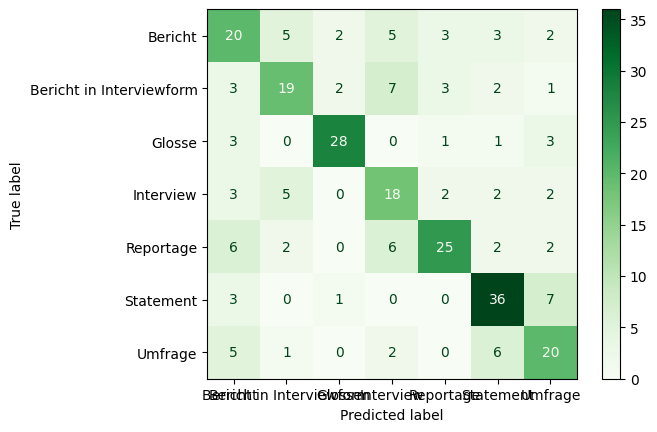

In [ ]:
# ... Matrix erstellen
y_pred = model.predict(X_test_16d)
cm = confusion_matrix(y_test_16d, y_pred)

# ... und visualisieren
class_names = np.unique(y_test_16d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

versuchen wir es nochmal mit tf-idf

In [ ]:
vectorizer = TfidfVectorizer(max_features=4000)
X = vectorizer.fit_transform(df["clean_text"])
y = df['gattung']

svd = TruncatedSVD(n_components=64, n_iter=100)
columns = ['topic{}'.format(i) for i in range(svd.n_components)]
svd_topic_vectors = svd.fit_transform(X)

df_svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns)
df_svd_topic_vectors

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic54,topic55,topic56,topic57,topic58,topic59,topic60,topic61,topic62,topic63
0,0.418902,-0.050397,-0.049013,0.015578,-0.046732,0.038827,0.036475,0.010366,0.000374,0.034246,...,-0.099168,0.082583,0.053462,-0.062457,0.053854,0.006249,-0.005935,-0.037863,0.030792,0.053143
1,0.318213,0.145437,0.022726,0.034103,0.007615,-0.042461,-0.013734,0.049171,0.035600,-0.065737,...,-0.012925,0.058758,-0.027298,0.006522,0.031756,-0.001909,0.007862,-0.005020,0.008608,0.045445
2,0.416282,0.114980,-0.074758,-0.043827,-0.016741,0.078877,-0.024363,0.097579,-0.039598,-0.152259,...,-0.063516,-0.019875,-0.070393,-0.012767,-0.024251,0.009130,0.019642,-0.016570,-0.023256,0.047419
3,0.387205,-0.063539,0.048778,0.077264,0.028482,0.134662,-0.073201,-0.094215,0.079055,-0.147222,...,0.071224,0.057770,-0.014510,-0.020283,-0.029663,0.034968,-0.071022,0.009300,-0.045225,-0.031849
4,0.468383,0.077887,-0.052491,-0.061149,0.085670,-0.046261,0.036495,0.063507,0.009276,-0.115190,...,-0.062537,-0.089180,-0.043742,0.050333,-0.005743,-0.028774,-0.075213,0.001864,-0.007919,-0.001172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0.401439,-0.051477,0.097374,0.066333,0.034264,-0.024290,-0.007373,0.087347,0.080479,-0.012421,...,0.022568,-0.014867,0.004085,-0.030723,0.012754,-0.020458,0.001144,-0.021587,0.018234,0.011632
1339,0.479846,0.098850,-0.019819,0.049798,-0.058165,0.011683,0.099636,0.024732,0.048708,0.034192,...,0.040964,0.004270,-0.001327,-0.074120,0.030601,0.045048,-0.035143,0.026166,0.033177,-0.013520
1340,0.584733,0.036965,0.031988,0.008520,-0.060758,0.017314,0.045147,-0.157215,0.067096,0.005436,...,-0.041853,-0.004378,-0.046994,0.062977,0.002767,-0.036631,0.044969,-0.038112,0.051382,0.034244
1341,0.322171,0.019969,-0.084451,-0.120406,-0.000671,-0.047928,0.020706,0.036179,-0.067210,0.023210,...,0.021299,-0.019366,0.018056,0.019751,-0.001844,0.040869,0.032703,-0.015086,0.013943,-0.028753


In [ ]:
X_train_16d, X_test_16d, y_train_16d, y_test_16d = train_test_split(df_svd_topic_vectors,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42)

lda_lsa = LinearDiscriminantAnalysis(n_components=6)
model = lda_lsa.fit(X_train_16d, y_train_16d)

print("Genauigkeit Trainingsset:", model.score(X_train_16d, y_train_16d))
print("Genauigkeit Testset:", model.score(X_test_16d, y_test_16d))

Genauigkeit Trainingsset: 0.7346368715083799
Genauigkeit Testset: 0.7026022304832714


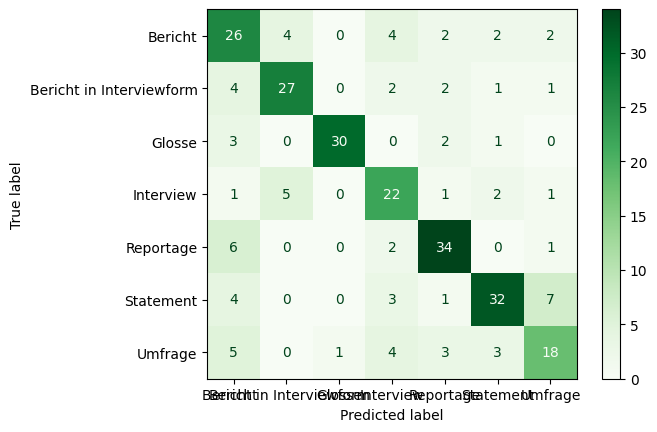

In [ ]:
# ... Matrix erstellen
y_pred = model.predict(X_test_16d)
cm = confusion_matrix(y_test_16d, y_pred)

# ... und visualisieren
class_names = np.unique(y_test_16d)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

Mit tf-idf funktioniert es tatsächlich deutlich besser. Habe den bisher besten Wert erreicht, der sich bereits den llm Ergebnissen annähert.

### Latent Dirichlet Allocation

In [ ]:
# Bag of Words schnüren

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation as LDiA


vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])
y = df['gattung']

ldia = LDiA(n_components=200, learning_method='batch')
ldia = ldia.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(ldia, y, test_size=0.2, random_state=42)

model = LinearDiscriminantAnalysis(n_components=None)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5707635009310987
0.4646840148698885


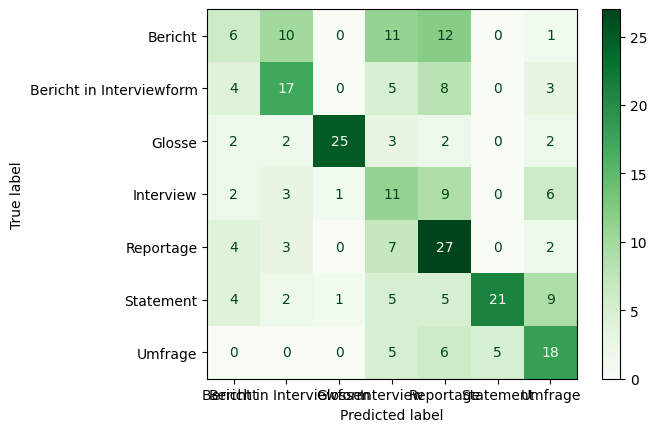

In [ ]:
# ... Matrix erstellen
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# ... und visualisieren
class_names = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

Eher nicht!

## Embeddings

In [ ]:
df['embedding_floats'] = df['embedding'].str.strip().str.split(',').apply(
    lambda x: [float(i) for i in x]
)

In [ ]:
embeddings = np.vstack(df['embedding_floats'].values)

In [ ]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
df["embedding_pca_x"] = embeddings_2d[:, 0]
df["embedding_pca_y"] = embeddings_2d[:, 1]

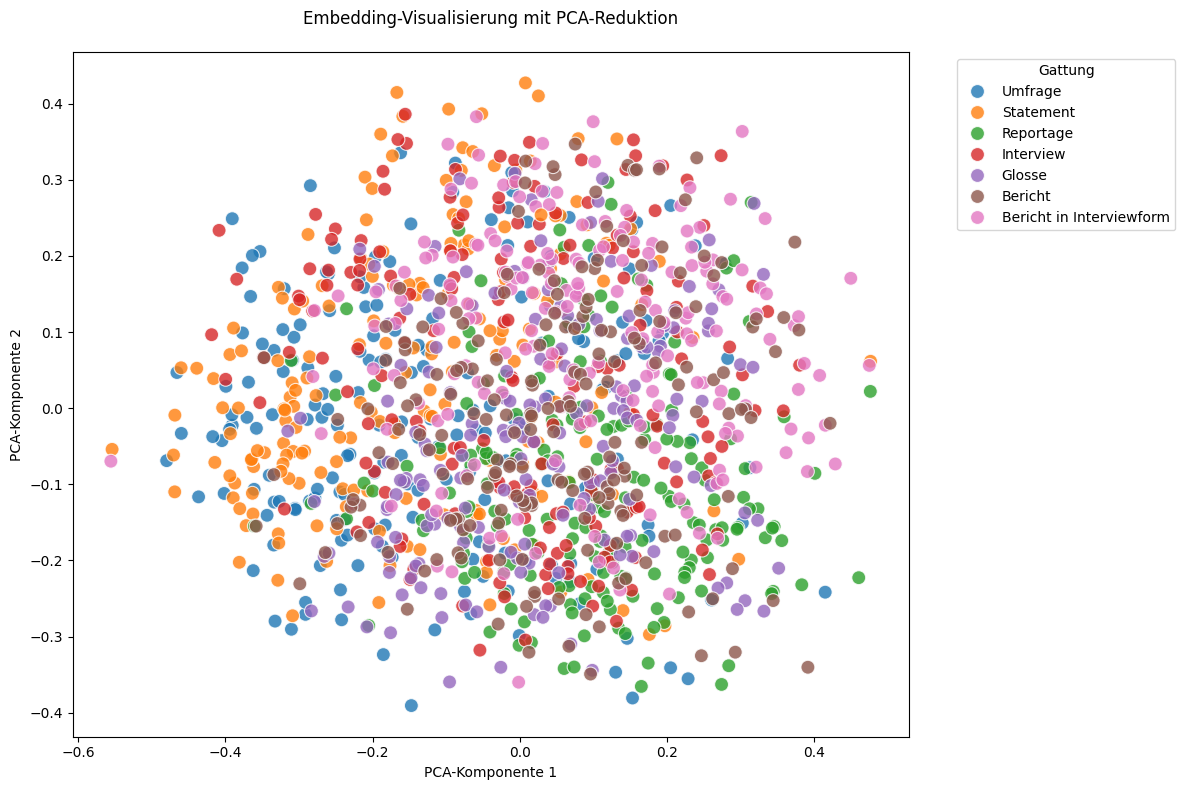

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='embedding_pca_x',
    y='embedding_pca_y',
    hue='gattung',
    palette='tab10',
    alpha=0.8,
    s=100,
    edgecolor='w'
)

plt.title('Embedding-Visualisierung mit PCA-Reduktion', pad=20)
plt.xlabel('PCA-Komponente 1')
plt.ylabel('PCA-Komponente 2')
plt.legend(bbox_to_anchor=(1.05, 1), title='Gattung')
plt.tight_layout()
plt.show()

Shit!

In [ ]:

# T-SNE mit typischen Einstellungen für Text-Embeddings
tsne = TSNE(
    n_components=2,
    perplexity=30,        # Testen Sie Werte zwischen 5-50
    learning_rate=200,   # Für kleinere Datensätze oft höher
    random_state=42,     # Reproduzierbarkeit
    init='pca'           # Bessere Initialisierung
)

embeddings_tsne = tsne.fit_transform(embeddings)

# Ergebnisse speichern
df["embedding_tsne_x"] = embeddings_tsne[:, 0]
df["embedding_tsne_y"] = embeddings_tsne[:, 1]

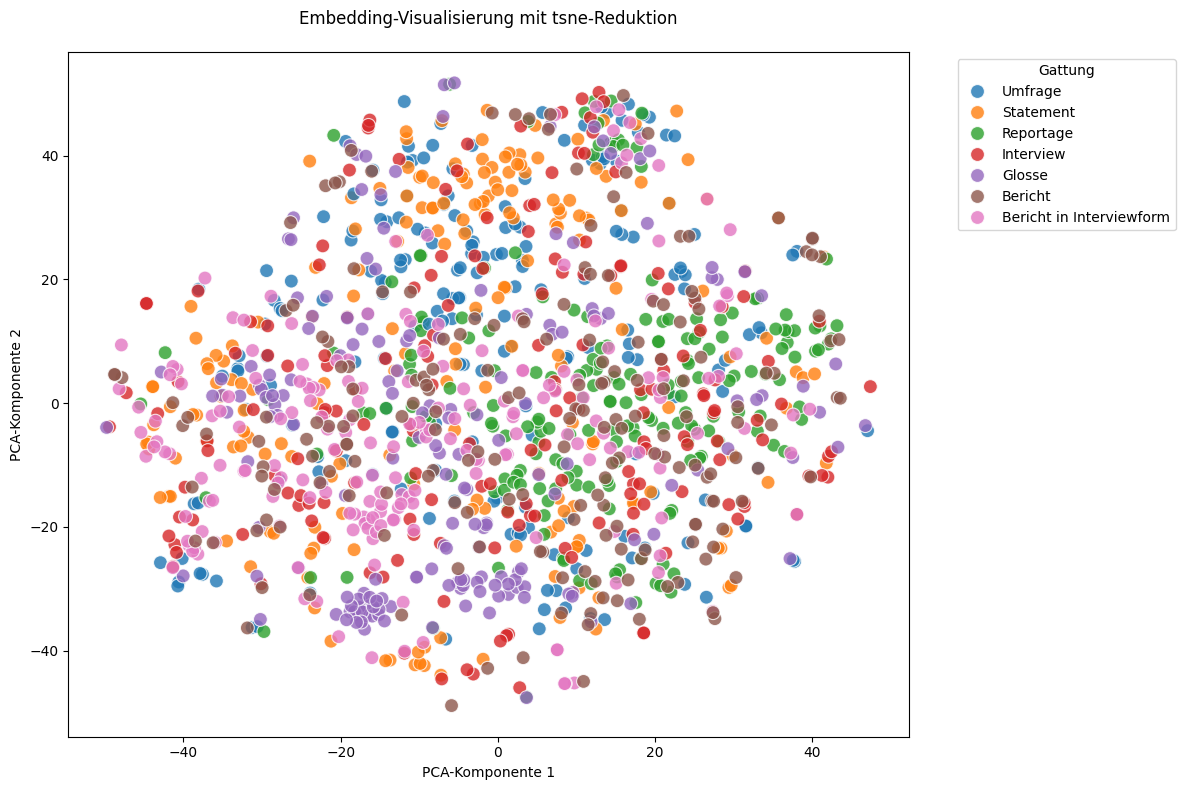

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='embedding_tsne_x',
    y='embedding_tsne_y',
    hue='gattung',
    palette='tab10',
    alpha=0.8,
    s=100,
    edgecolor='w'
)

plt.title('Embedding-Visualisierung mit tsne-Reduktion', pad=20)
plt.xlabel('PCA-Komponente 1')
plt.ylabel('PCA-Komponente 2')
plt.legend(bbox_to_anchor=(1.05, 1), title='Gattung')
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized,embedding_floats,embedding_pca_x,embedding_pca_y,embedding_tsne_x,embedding_tsne_y
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...,"[0.015333812683820001, 0.021696707233786, -0.0...",0.152688,0.234409,-32.041004,-0.994150
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...,"[0.033938158303499, -0.058570936322212004, -0....",-0.271028,-0.206749,-7.243228,45.217102
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...,"[0.08172919601202, -0.06428052484989101, 0.020...",-0.334333,-0.179743,5.496624,18.334984
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...,"[0.045513272285461, 0.023429902270436002, -0.0...",-0.066274,-0.270241,16.729895,9.585168
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...,"[0.034393869340419006, -0.038432110100984004, ...",-0.242054,-0.277958,7.425843,-30.305819


### Ähnlichkeit mit den Zentroiden

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Daten konvertieren (falls nötig)
# df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

# 2. Korrekte Train/Test-Split
X = df[['embedding_floats']]  # Features als DataFrame
y = df['gattung']      # Labels

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# 3. GroupBy auf TRAIN-Daten mit y_train
train_df = X_train.copy()
train_df['gattung'] = y_train  # Label wieder hinzufügen

centroids = train_df.groupby('gattung')['embedding_floats'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).to_dict()

# 4. Vorhersage auf Testdaten
def predict_nearest_label(test_embedding, centroids):
    labels = list(centroids.keys())
    centroid_vectors = np.vstack(list(centroids.values()))

    # Wichtig: test_embedding als 2D-Array
    dist_idx = pairwise_distances_argmin_min(
        test_embedding.reshape(1, -1),
        centroid_vectors
    )[0][0]

    return labels[dist_idx]

# Anwendung
X_test['predicted_label'] = X_test['embedding_floats'].apply(
    lambda x: predict_nearest_label(np.array(x), centroids)
)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Daten konvertieren (falls nötig)
# df['embedding'] = df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

# 2. Korrekte Train/Test-Split
X = df[['embedding_floats']]  # Features als DataFrame
y = df['gattung']      # Labels

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# 3. GroupBy auf TRAIN-Daten mit y_train
train_df = X_train.copy()
train_df['gattung'] = y_train  # Label wieder hinzufügen

centroids = train_df.groupby('gattung')['embedding_floats'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).to_dict()

# 4. Vorhersage auf Testdaten
def predict_nearest_label(test_embedding, centroids):
    labels = list(centroids.keys())
    centroid_vectors = np.vstack(list(centroids.values()))

    # Wichtig: test_embedding als 2D-Array
    dist_idx = pairwise_distances_argmin_min(
        test_embedding.reshape(1, -1),
        centroid_vectors
    )[0][0]

    return labels[dist_idx]

# Anwendung
X_test['predicted_label'] = X_test['embedding_floats'].apply(
    lambda x: predict_nearest_label(np.array(x), centroids)
)

Model Accuracy: 47.58%

                          precision    recall  f1-score   support

                 Bericht       0.57      0.40      0.47        40
Bericht in Interviewform       0.36      0.43      0.39        37
                  Glosse       0.60      0.67      0.63        36
               Interview       0.12      0.09      0.11        32
               Reportage       0.58      0.77      0.66        43
               Statement       0.56      0.43      0.48        47
                 Umfrage       0.41      0.47      0.44        34

                accuracy                           0.48       269
               macro avg       0.46      0.47      0.45       269
            weighted avg       0.47      0.48      0.47       269



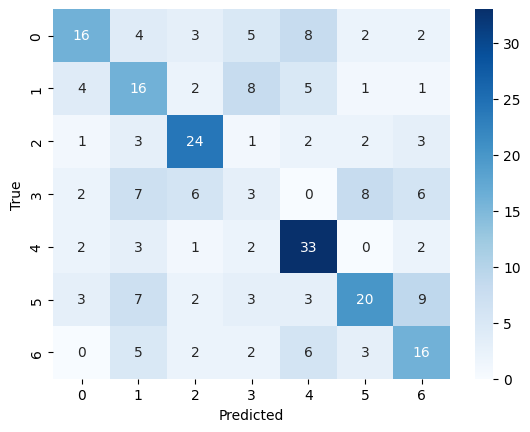

In [ ]:
from sklearn.metrics import accuracy_score

# 1. Tatsächliche Labels und Vorhersagen vergleichen
y_true = y_test  # Echte Labels aus dem Testset
y_pred = X_test['predicted_label']  # Vorhergesagte Labels

# 2. Accuracy berechnen
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# 3. Optional: Detaillierter Classification Report
from sklearn.metrics import classification_report
print("\n" + classification_report(y_true, y_pred))

# 4. Optional: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Versuchen wir es nochmal mit Normalisierung der Embeddings

In [ ]:
from sklearn.preprocessing import normalize

# 1. Normalisierung der Embeddings (bereits während der Datenspeicherung)
# df['normalized_embedding'] = df['embedding_floats'].apply(
#    lambda x: normalize(np.array(x).reshape(1, -1))[0]
# )

# ODER zur Laufzeit (effizienter):
X_train['normalized'] = X_train['embedding_floats'].apply(
    lambda x: normalize(np.array(x).reshape(1, -1))[0]
)
X_test['normalized'] = X_test['embedding_floats'].apply(
    lambda x: normalize(np.array(x).reshape(1, -1))[0]
)

# 2. Centroiden-Berechnung mit normalisierten Vektoren
train_df = X_train.copy()
train_df['gattung'] = y_train

centroids = train_df.groupby('gattung')['normalized'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).to_dict()

# 3. Vorhersage-Funktion mit normalisierten Embeddings
def predict_nearest_label(test_embedding, centroids):
    labels = list(centroids.keys())
    centroid_vectors = np.vstack(list(centroids.values()))

    # Wichtig: Test-Embedding ebenfalls normalisieren
    norm_test = normalize(test_embedding.reshape(1, -1))

    dist_idx = pairwise_distances_argmin_min(
        norm_test,  # Verwende normierte Vektoren
        centroid_vectors,
        metric='cosine'  # Explizite Angabe der Metrik
    )[0][0]

    return labels[dist_idx]

# Anwendung mit normalisierten Testdaten
X_test['predicted_label'] = X_test['normalized'].apply(
    lambda x: predict_nearest_label(np.array(x), centroids)
)

Model Accuracy: 47.21%

                          precision    recall  f1-score   support

                 Bericht       0.61      0.42      0.50        40
Bericht in Interviewform       0.35      0.46      0.40        37
                  Glosse       0.60      0.69      0.64        36
               Interview       0.14      0.12      0.13        32
               Reportage       0.56      0.72      0.63        43
               Statement       0.57      0.34      0.43        47
                 Umfrage       0.42      0.50      0.46        34

                accuracy                           0.47       269
               macro avg       0.47      0.47      0.46       269
            weighted avg       0.48      0.47      0.46       269



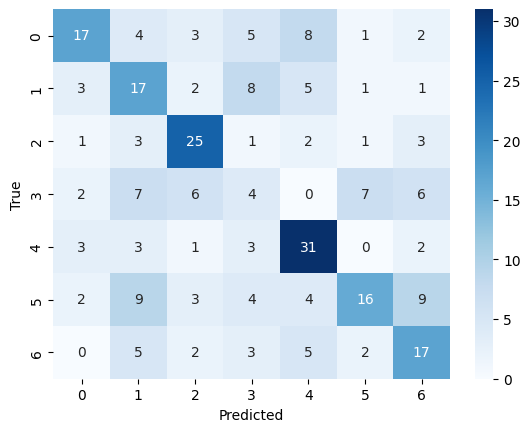

In [ ]:
from sklearn.metrics import accuracy_score

# 1. Tatsächliche Labels und Vorhersagen vergleichen
y_true = y_test  # Echte Labels aus dem Testset
y_pred = X_test['predicted_label']  # Vorhergesagte Labels

# 2. Accuracy berechnen
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# 3. Optional: Detaillierter Classification Report
from sklearn.metrics import classification_report
print("\n" + classification_report(y_true, y_pred))

# 4. Optional: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Embeddings und SVM

In [ ]:
X = pd.DataFrame(df["embedding_floats"].tolist())
y = df["gattung"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(C=1, gamma="scale", kernel="linear")
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7197392923649907
0.4758364312267658


### Embeddings und Random Forest

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.44609665427509293


Overfitting!

### Embeddings und LDA

In [ ]:
model = LinearDiscriminantAnalysis(n_components=6)
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9962756052141527
0.3159851301115242


Overfitting!

In [ ]:
X.shape

(1343, 768)

Hab überall ein overfitting Problem. Versuche, die Dimensionalität weiter zu reduzieren?

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# RFE mit SVC im Pipeline-Design
rfe = RFE(
    estimator=SVC(kernel="linear", C=1),  # Basis-Modell für Feature-Bewertung
    n_features_to_select=30,  # Startwert, später optimieren
    step=0.1  # 10% der Features pro Iteration entfernen
)

model = Pipeline(steps=[
    ('feature_selector', rfe),
    ('classifier', SVC(C=1, gamma="scale", kernel="linear"))
])

model.fit(X_train, y_train)

print(f"Train Score: {model.score(X_train, y_train):.3f}")
print(f"Test Score: {model.score(X_test, y_test):.3f}")

# Wichtige Features analysieren
support_mask = model.named_steps['feature_selector'].support_
print(f"Behaltene Features: {sum(support_mask)}")


Train Score: 0.467
Test Score: 0.454
Behaltene Features: 30


Train Score: 1.000
Test Score: 0.394
Anzahl Komponenten: 182
Erklärte Varianz: 95.06%


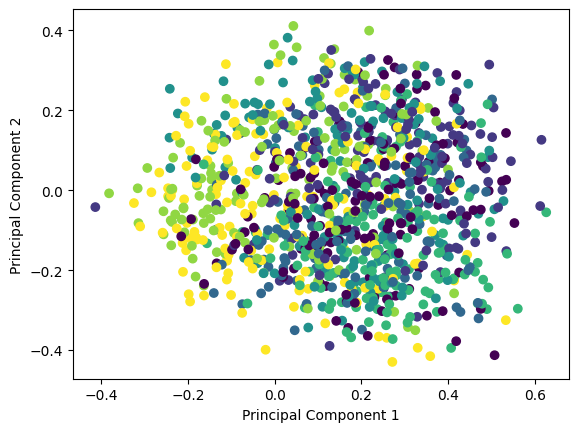

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Wichtig für PCA!


# Pipeline mit Skalierung und PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Kritischer Schritt für PCA[1][6]
    ('pca', PCA(n_components=0.95)),  # Behält 95% Varianz bei[6][7]
    ('svc', SVC(C=1, gamma="scale", kernel="linear"))  # Dein bestehendes Modell
])

pipeline.fit(X_train, y_train)

# Ergebnisse ausgeben
print(f"Train Score: {pipeline.score(X_train, y_train):.3f}")
print(f"Test Score: {pipeline.score(X_test, y_test):.3f}")

# PCA-Analyse
pca = pipeline.named_steps['pca']
print(f"Anzahl Komponenten: {pca.n_components_}")
print(f"Erklärte Varianz: {pca.explained_variance_ratio_.sum():.2%}")

# Optional: Visualisierung der ersten 2 Komponenten
import matplotlib.pyplot as plt

X_pca = pca.transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train.astype('category').cat.codes)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Das verfolge ich eher nicht mehr weiter :( Next try **SDCClassifier** wie hier beschrieben: https://itnext.io/text-classification-with-vector-embeddings-and-no-ml-model-c793c09698f0.

### Scaled Dimension Combination (SCD)

**Idee:**

Der SDCClassifier berechnet den Durchschnittsvektor für jedes Label. Hierdurch werden die charakteristischen Dimensionen jedes Merkmals hervorgehoben. Weniger charakteristische Dimensionen, die eine hohe Varianz aufweisen, werden entsprechend nivelliert. Anschließend wird ein Score mit Hilfe einer Matrixoperation berechnet: der Durchschnittsvektor wird mit dem Embedding eines Dokuments multipliziert und die Werte danach addiert, hierdurch ergibt sich für jeden Wert ein Skalarprodukt, das höher ist, je stärker das Embedding mit den charakterisischen Dimensionen des Durchschnittsvektors übereinstimmt.

**Hypothese:**

Im Gegensatz zur Cosinusähnlichkeit werden hier vor allem die Dimensionen eines Verktor-Embeddings betrachtet, die charakteristisch für ein bestimmtes Label sind und nicht alle gleichzeitig. Die Ergebnisse sind deshalb besser.

In [ ]:
class SDCClassifier:
    def train(self, X, y):
        X = np.array(X)
        y = np.array(y)
        unique_labels = set(y)
        if len(unique_labels) == 0:
            raise ValueError("Keine Labels in y vorhanden")

        self.signatures = []
        for label in unique_labels:
            class_samples = X[y == label]
            if len(class_samples) == 0:
                raise ValueError(f"Klasse {label} hat keine Samples")
            self.signatures.append((label, class_samples.mean(0)))

    def predict_one(self, embedding):
        predicted_label, score = max(
            ((label, embedding @ sig) for label, sig in self.signatures),
            key=lambda x: x[1],
        )
        return predicted_label

    def predict(self, X):
        X = np.array(X)
        return list(map(self.predict_one, X))

In [ ]:
# normalisiern
X_normalized = (X - X.mean()) / X.std()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

model = SDCClassifier()
model.train(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

                          precision    recall  f1-score   support

                 Bericht       0.60      0.15      0.24        40
Bericht in Interviewform       0.37      0.43      0.40        37
                  Glosse       0.51      0.67      0.58        36
               Interview       0.18      0.06      0.09        32
               Reportage       0.45      0.81      0.58        43
               Statement       0.52      0.47      0.49        47
                 Umfrage       0.38      0.44      0.41        34

                accuracy                           0.45       269
               macro avg       0.43      0.43      0.40       269
            weighted avg       0.44      0.45      0.41       269



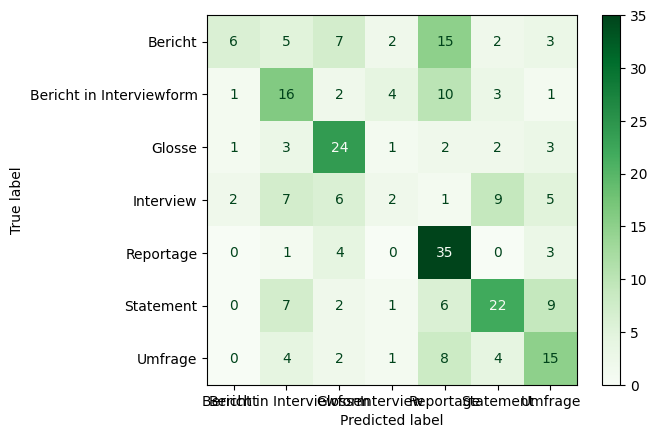

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# ... und visualisieren
class_names = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.show()

Insgesamt performen alle bisherigen Embedding-Ansätze nicht gut. Es könnte sein, dass der Embedder nicht gut dafür geeignet ist, die spezifischen Charakteristika abzubilden, die typisch für die Gattungen sind. Im oben verlinkten Artikel zu SDC machen die Embedder z.T. einen erheblichen Unterschied. Dort scheint zu gelten: je mehr Dimensionen, desto besser die Ergebnisse.

Das testen wir irgendwann hier!

## **CNN-Übung 1: Binäre Klassifikation**

Hier ist der einfachste CNN-Code für Textklassifikation mit TensorFlow. Da CNNs eigentlich für Bilddaten konzipiert sind, müssen wir den Text zunächst in numerische Vektoren umwandeln und als 2D-Matrix darstellen:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Reshape, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/jaeniboy/nlp-genres/refs/heads/main/train.csv?token=GHSAT0AAAAAADDNF7SCRGU2O4CM5JHURICE2A2LR3Q")
df = df[['text', 'target']]

In [ ]:
from collections import Counter

Counter(df["target"])

Counter({1: 3271, 0: 4342})

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-05-06 19:03:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-06 19:03:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-06 19:03:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
GLOVE = True

# 1. Daten vorbereiten
X = df['text'].values
y = df['target'].astype('int32').values

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# 2. Text-Vektorisierung
VOCAB_SIZE = 5000
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE,
                               output_sequence_length=100,
                               dtype='int32' # notwendig, da von Embedding-Layer gefordert
                              )
vectorizer.adapt(X_train)

embedder = None

# implementiere vortrainierte Word-Embeddings
if GLOVE:
    # Wort-Index abrufen
    print(f"Embedding: Glove")
    word_index = vectorizer.get_vocabulary()
    word_index = dict(zip(word_index, range(len(word_index))))

    glove_path = 'glove.6B.300d.txt'
    embedding_dim = 300
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))
    oov_count = 0

    with open(glove_path, encoding='utf-8') as f:
        glove_embeddings = {}
        for line in f:
            word, *vector = line.split()
            glove_embeddings[word] = np.array(vector, dtype='float32')

    for word, i in word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                oov_count += 1

    print(f"Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): {oov_count}")

    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=embedding_dim,
                         embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                           trainable=False)
# Alternative: erstelle Embeddings on the fly ausschließlich aus dem Korpus
else:
    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=128,
                         trainable=True)

Embedding: Glove
Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): 550


In [ ]:

# 3. CNN Modell
model = tf.keras.Sequential([
    vectorizer,
    embedder,
    Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 4, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

# 4. Kompilieren und trainieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5814 - loss: 0.7157 - val_accuracy: 0.7515 - val_loss: 0.5329
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7499 - loss: 0.5124 - val_accuracy: 0.7754 - val_loss: 0.4916
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.7953 - loss: 0.4542 - val_accuracy: 0.7892 - val_loss: 0.4725
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8200 - loss: 0.4188 - val_accuracy: 0.7994 - val_loss: 0.4603
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8389 - loss: 0.3939 - val_accuracy: 0.8014 - val_loss: 0.4530
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.8528 - loss: 0.3645 - val_accuracy: 0.8066 - val_loss: 0.4476
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.8665 - loss: 0.3533 - val_accuracy: 0.8076 - val_loss: 0.4431
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8758 - loss: 0.3337 - va

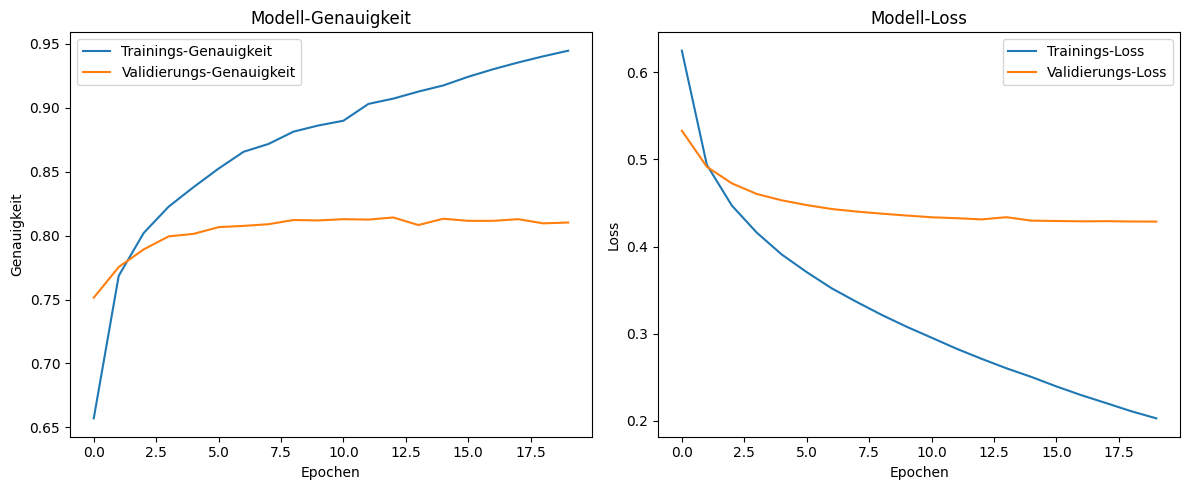

In [ ]:
import matplotlib.pyplot as plt

# Erstelle zwei Subplots nebeneinander
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trainings-Genauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungs-Genauigkeit')
plt.title('Modell-Genauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trainings-Loss')
plt.plot(history.history['val_loss'], label='Validierungs-Loss')
plt.title('Modell-Loss')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **CNN-Übung 2: Multiclass**

In [ ]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization, Embedding

In [ ]:
df = pd.read_csv("consumer_complaints.csv")

C:\Users\janfs\AppData\Local\Temp\ipykernel_18120\927148996.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consumer_complaints.csv")


In [ ]:
# keep only rows with consumer complaint_narrative
df = df[~df["consumer_complaint_narrative"].isna()].copy().reset_index()
df.head(3)

,index,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524


In [ ]:
Counter(df["product"])

Counter({'Debt collection': 17552,
         'Mortgage': 14919,
         'Credit reporting': 12526,
         'Credit card': 7929,
         'Bank account or service': 5711,
         'Consumer Loan': 3678,
         'Student loan': 2128,
         'Prepaid card': 861,
         'Payday loan': 726,
         'Money transfers': 666,
         'Other financial service': 110})

In [ ]:
df["consumer_complaint_narrative"]

0        XXXX has claimed I owe them {$27.00} for XXXX ...
1        Due to inconsistencies in the amount owed that...
2        In XX/XX/XXXX my wages that I earned at my job...
3        I have an open and current mortgage with Chase...
4        XXXX was submitted XX/XX/XXXX. At the time I s...
                               ...                        
66801    XXXX XXXX is reporting incorrectly, payments h...
66802    Reflecting incorrect payment status. Have been...
66803    I have been paying {$180.00} a month through d...
66804    I recently became aware that Amerisave Mortgag...
66805    Bank of America has demonstrated an on-going l...
Name: consumer_complaint_narrative, Length: 66806, dtype: object

In [ ]:
X = df["consumer_complaint_narrative"].values
labels = df["product"].values

le = LabelEncoder()
y = le.fit_transform(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
# 2. Text-Vektorisierung
VOCAB_SIZE = 5000
GLOVE = True
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE,
                               output_sequence_length=100,
                               dtype='int32' # notwendig, da von Embedding-Layer gefordert
                              )
vectorizer.adapt(X_train)

embedder = None

# implementiere vortrainierte Word-Embeddings
if GLOVE:
    # Wort-Index abrufen
    print(f"Embedding: Glove")
    word_index = vectorizer.get_vocabulary()
    word_index = dict(zip(word_index, range(len(word_index))))

    glove_path = 'glove.6B.300d.txt'
    embedding_dim = 300
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))
    oov_count = 0

    with open(glove_path, encoding='utf-8') as f:
        glove_embeddings = {}
        for line in f:
            word, *vector = line.split()
            glove_embeddings[word] = np.array(vector, dtype='float32')

    for word, i in word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                oov_count += 1

    print(f"Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): {oov_count}")

    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=embedding_dim,
                         embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                           trainable=False)
# Alternative: erstelle Embeddings on the fly ausschließlich aus dem Korpus
else:
    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=128,
                         trainable=True)

Embedding: Glove
Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): 242


In [ ]:
model = tf.keras.Sequential([
    vectorizer,
    embedder,
    Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 4, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    GlobalMaxPooling1D(),
    Dense(11, activation='softmax')
])

# 4. Kompilieren und trainieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=5,
          batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.5575 - loss: 1.4126 - val_accuracy: 0.7597 - val_loss: 0.7961
Epoch 2/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.7736 - loss: 0.7405 - val_accuracy: 0.7946 - val_loss: 0.6748
Epoch 3/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8143 - loss: 0.6126 - val_accuracy: 0.8131 - val_loss: 0.6143
Epoch 4/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - accuracy: 0.8287 - loss: 0.5604 - val_accuracy: 0.8193 - val_loss: 0.5858
Epoch 5/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.8412 - loss: 0.5202 - val_accuracy: 0.8254 - val_loss: 0.5701
Epoch 6/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.8492 - loss: 0.4898 - val_accuracy: 0.8270 - val_loss: 0.5592
Epoch 7/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8608 - loss: 0.4618 - val_accuracy: 0.8296 - val_loss: 0.5506
Epoch 8/20
1671/1671 ━━━━━━━━━━━━━━━━━━━━ 45s 27ms/step - accuracy: 0.8660 -

In [ ]:
import matplotlib.pyplot as plt

def plot_curve(hist):
# Erstelle zwei Subplots nebeneinander
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Trainings-Genauigkeit')
    plt.plot(hist.history['val_accuracy'], label='Validierungs-Genauigkeit')
    plt.title('Modell-Genauigkeit')
    plt.xlabel('Epochen')
    plt.ylabel('Genauigkeit')
    plt.legend()

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Trainings-Loss')
    plt.plot(hist.history['val_loss'], label='Validierungs-Loss')
    plt.title('Modell-Loss')
    plt.xlabel('Epochen')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

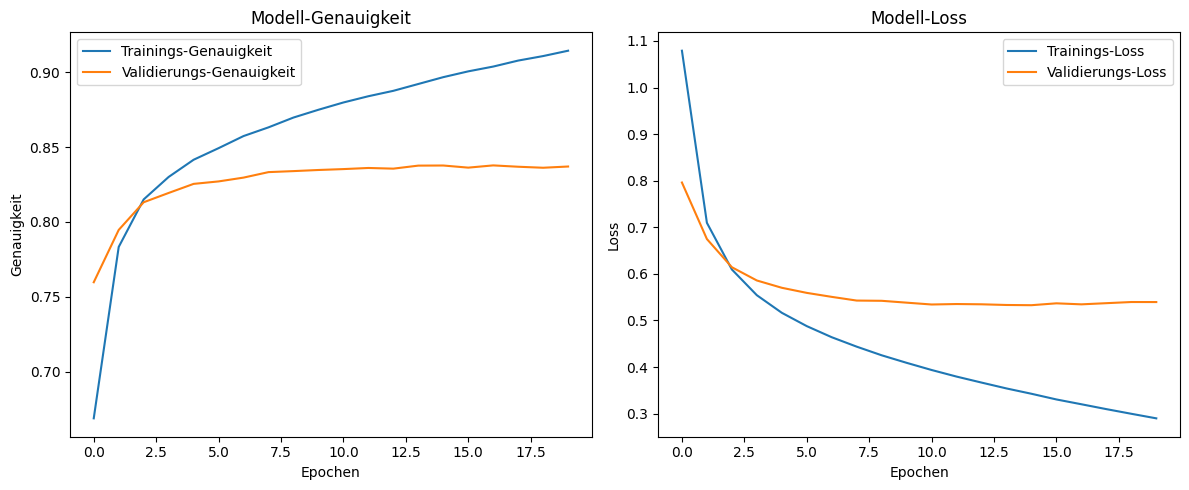

In [ ]:
plot_curve(history)

In [ ]:
text = X[0]
neue_daten = tf.convert_to_tensor([text])
vorhersagen = model.predict(neue_daten)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


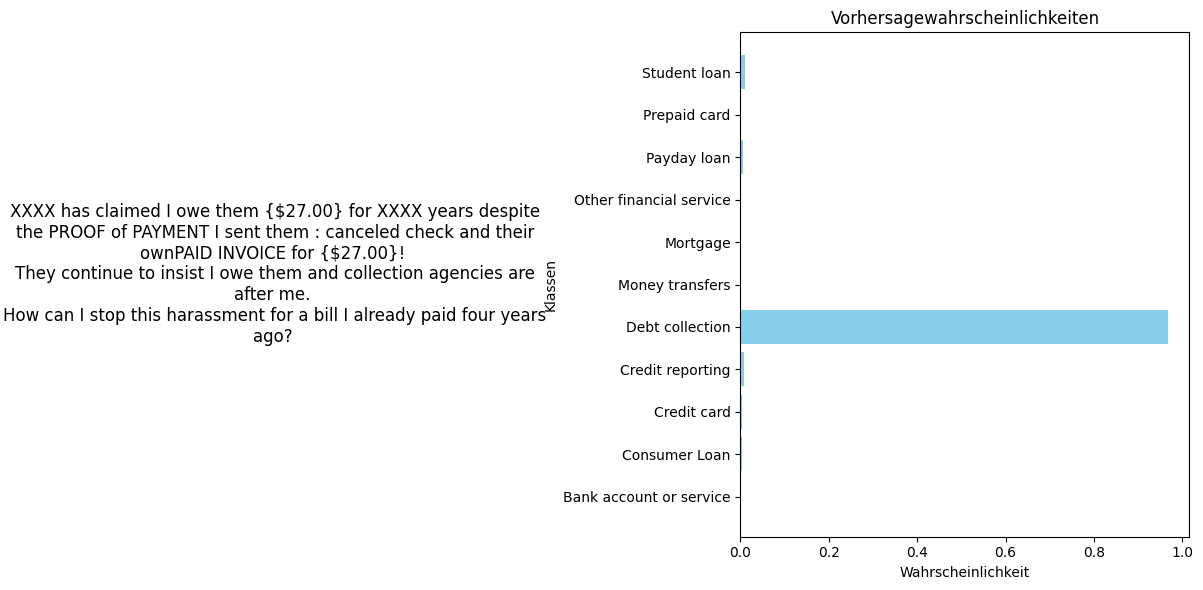

In [ ]:
# Subplots mit 1 Zeile, 2 Spalten erstellen
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6),
                                       gridspec_kw={'width_ratios': [1, 2]})

ax_left.text(0.5, 0.5, text,
            ha='center', va='center',
            wrap=True,
            fontsize=12)
ax_left.axis('off')  # Achsen ausblenden

# Rechte Seite: Balkendiagramm
ax_right.barh(le.classes_, probs, color='skyblue')
ax_right.set_title('Vorhersagewahrscheinlichkeiten')
ax_right.set_xlabel('Wahrscheinlichkeit')
ax_right.set_ylabel('Klassen')

# Layout optimieren
plt.tight_layout()
plt.show()

## CNN: jetzt echt!

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, class_names):
    """
    Generiert und visualisiert die Confusion Matrix für ein Klassifikationsmodell.

    Args:
        model: Das trainierte Klassifikationsmodell (mit einer predict-Methode).
        X_test: Die Testdaten.
        y_test: Die wahren Labels für die Testdaten.
        class_names: Eine Liste der Klassennamen in der Reihenfolge ihrer Indizes.
    """
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Konvertiere Wahrscheinlichkeiten zu Klassenlabels

    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahrheit')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.initializers import Constant

In [ ]:
X = df["transcript"].values
labels = df["gattung"].values

le = LabelEncoder()
y = le.fit_transform(labels)

num_classes = len(le.classes_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [ ]:
y_train

array([3, 2, 0, ..., 0, 2, 1])

In [ ]:
# 2. Text-Vektorisierung
GLOVE = True

VOCAB_SIZE = 5000
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE,
                               output_sequence_length=1000,
                               dtype='int32' # notwendig, da von Embedding-Layer gefordert
                              )
vectorizer.adapt(X_train)

embedder = None

# implementiere vortrainierte Word-Embeddings
if GLOVE:
    # Wort-Index abrufen
    print(f"Embedding: Glove")
    word_index = vectorizer.get_vocabulary()
    word_index = dict(zip(word_index, range(len(word_index))))

    glove_path = 'glove.6B.300d.txt'
    embedding_dim = 300
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))
    oov_count = 0

    with open(glove_path, encoding='utf-8') as f:
        glove_embeddings = {}
        for line in f:
            word, *vector = line.split()
            glove_embeddings[word] = np.array(vector, dtype='float32')

    for word, i in word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                oov_count += 1

    print(f"Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): {oov_count}")

    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=embedding_dim,
                         embeddings_initializer=Constant(embedding_matrix),
                           trainable=False)
# Alternative: erstelle Embeddings on the fly ausschließlich aus dem Korpus
else:
    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=128,
                         trainable=True)

Embedding: Glove
Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): 2903


In [ ]:
model = Sequential([
    vectorizer,
    embedder,
    Conv1D(128, 3, activation='relu', padding="same"),
    Dropout(0.3),
    Conv1D(128, 4, activation='relu', padding="same"),
    Dropout(0.3),
    Conv1D(128, 5, activation='relu', padding="same"),
    Dropout(0.3),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# 4. Kompilieren und trainieren
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=20,
          batch_size=32,
          validation_data=(X_test, y_test))

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.1558 - loss: 2.0318 - val_accuracy: 0.2602 - val_loss: 1.9253
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.2032 - loss: 1.9191 - val_accuracy: 0.1747 - val_loss: 1.9255
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2438 - loss: 1.9038 - val_accuracy: 0.2379 - val_loss: 1.8763
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2926 - loss: 1.7758 - val_accuracy: 0.3234 - val_loss: 1.7744
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3264 - loss: 1.6379 - val_accuracy: 0.2639 - val_loss: 1.8000
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3346 - loss: 1.6420 - val_accuracy: 0.3048 - val_loss: 1.6526
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3951 - loss: 1.4903 - val_accuracy: 0.3271 - val_loss: 1.6211
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.3880 - loss: 1.4890 - val_accuracy: 0.2937 - val_loss:

In [ ]:
plot_curve(history)

NameError: name 'plot_curve' is not defined

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step


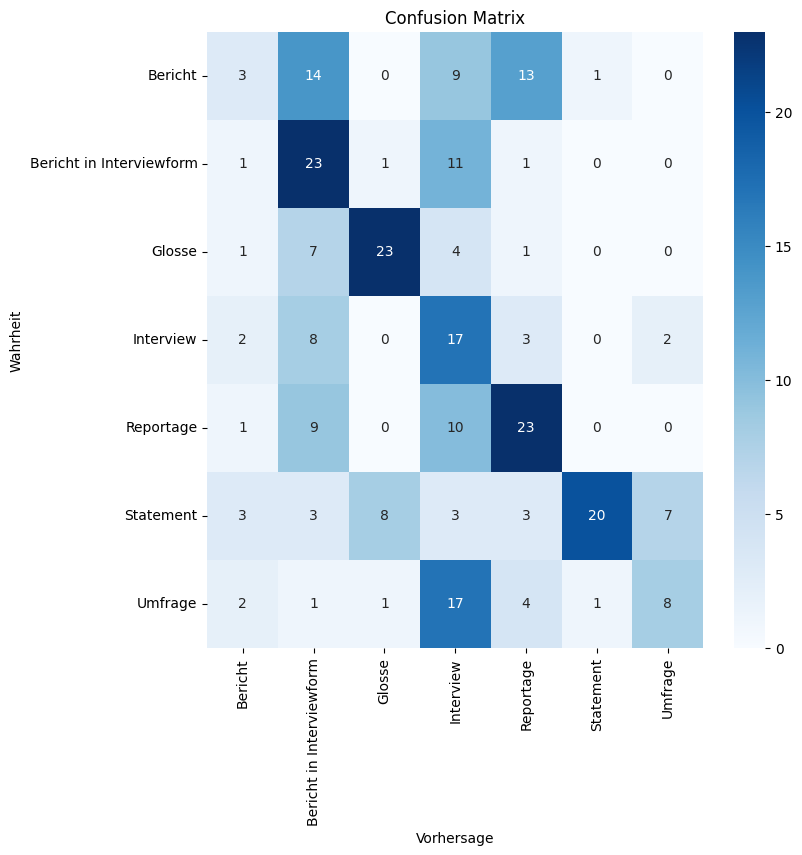

In [ ]:
plot_confusion_matrix(model, X_test, y_test, le.classes_)

### Nochmal ein Durchlauf mit den Übungsdaten, aber testweise mit deutlich kleinerem Datensatz

In [ ]:
df = pd.read_csv("consumer_complaints.csv")
df = df[~df["consumer_complaint_narrative"].isna()].copy().reset_index()

# Anzahl pro Produkt berechnen (1200/11 ≈ 109 pro Gruppe)
n_per_product = 110

# Stratifizierte Stichprobe ziehen
strat_sample = (
    df.groupby('product')
    .apply(lambda x: x.sample(n=n_per_product, random_state=42), include_groups=True)
    .reset_index(drop=True)
)

X = strat_sample["consumer_complaint_narrative"].values
labels = strat_sample["product"].values

le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# 2. Text-Vektorisierung
VOCAB_SIZE = 5000
GLOVE = True
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE,
                               output_sequence_length=100,
                               dtype='int32' # notwendig, da von Embedding-Layer gefordert
                              )
vectorizer.adapt(X_train)

embedder = None

# implementiere vortrainierte Word-Embeddings
if GLOVE:
    # Wort-Index abrufen
    print(f"Embedding: Glove")
    word_index = vectorizer.get_vocabulary()
    word_index = dict(zip(word_index, range(len(word_index))))

    glove_path = 'glove.6B.300d.txt'
    embedding_dim = 300
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))
    oov_count = 0

    with open(glove_path, encoding='utf-8') as f:
        glove_embeddings = {}
        for line in f:
            word, *vector = line.split()
            glove_embeddings[word] = np.array(vector, dtype='float32')

    for word, i in word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = glove_embeddings.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
            else:
                oov_count += 1

    print(f"Anzahl der OOV-Wörter (im Vokabular, aber nicht in GloVe gefunden): {oov_count}")

    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=embedding_dim,
                         embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                           trainable=False)
# Alternative: erstelle Embeddings on the fly ausschließlich aus dem Korpus
else:
    embedder = Embedding(input_dim=VOCAB_SIZE + 1,
                         output_dim=128,
                         trainable=True)

model = tf.keras.Sequential([
    vectorizer,
    embedder,
    Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 4, activation='relu', padding="same"),
    #Dropout(0.4),
    #Conv1D(64, 5, activation='relu', padding="same"),
    #Dropout(0.4),
    GlobalMaxPooling1D(),
    Dense(11, activation='softmax')
])

# 4. Kompilieren und trainieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=40,
          batch_size=32,
          validation_data=(X_test, y_test))

Mit einem ähnlich großen Datensatz, wie der aus der HFDB ist die Performance deutlich schlechter. Hinzu kommt die vermutlich höhere Kohärenz und das geringere Rauschen der Daten hier. Ist also eher kein Wunder, dass es nicht so richtig funktioniert.

### Fine-Tuning eines Transformer-Modells

Das Finetuning eines Transformer-Modells wegen fehlender GPU nach Colab ausgelagert: https://colab.research.google.com/drive/1lzadr-TuZOVYhT3cuSwWDNJycfaPJXmq#scrollTo=nKB2SS59mvah

## RNN

In [4]:
df

,transcript,gattung,embedding,word_count,char_count,avr_sentence_length,clean_text,text_stopwordless,tokens,text_lemmatized
0,Vor der letzten Bundestagswahl waren sie absol...,Umfrage,"0.015333812683820001, 0.021696707233786, -0.07...",262,1643,73.73,vor der letzten bundestagswahl waren sie absol...,letzten bundestagswahl waren absolut umfrageho...,"[Vor, der, letzten, Bundestagswahl, waren, sie...",letzter Bundestagswahl sein absolut Umfragehoc...
1,"He ute ist Weltknuddeltag, was es nicht alles ...",Umfrage,"0.033938158303499, -0.058570936322212004, -0.0...",290,1759,66.69,he ute ist weltknuddeltag was es nicht alles g...,he ute weltknuddeltag alles gibt weltknuddelta...,"[He, ute, ist, Weltknuddeltag, ,, was, es, nic...",he ute Weltknuddeltag alle geben Weltknuddelta...
2,"47 elf, Grrrls Wasser ja, hat meine Mutter imm...",Umfrage,"0.08172919601202, -0.06428052484989101, 0.0208...",222,1323,59.18,47 elf grrrls wasser ja hat meine mutter immer...,47 elf grrrls wasser hat mutter immer gekauft ...,"[47, elf, ,, Grrrls, Wasser, ja, ,, hat, meine...",47 elf grrrls Wasser haben Mutter immer kaufen...
3,"Ja, meint die Atmosphäre. Im Endeffekt gehört ...",Umfrage,"0.045513272285461, 0.023429902270436002, -0.06...",115,702,77.11,ja meint die atmosphäre im endeffekt gehört di...,meint atmosphäre endeffekt gehört leute allem ...,"[Ja, ,, meint, die, Atmosphäre, ., Im, Endeffe...",meinen Atmosphäre Endeffekt gehören leute alle...
4,"Gestern Abend großes Familienfest, vielleicht ...",Umfrage,"0.034393869340419006, -0.038432110100984004, -...",333,2062,67.77,gestern abend großes familienfest vielleicht d...,gestern abend großes familienfest vielleicht i...,"[Gestern, Abend, großes, Familienfest, ,, viel...",gestern abend groß Familienfest vielleicht ihn...
...,...,...,...,...,...,...,...,...,...,...
1356,"Da hüpft ein kleines Roboterbein im Kreis, es ...",Bericht,"0.046196766197681004, 0.041371896862983, -0.07...",276,1894,93.75,da hüpft ein kleines roboterbein im kreis es s...,hüpft kleines roboterbein kreis sieht känguru ...,"[Da, hüpft, ein, kleines, Roboterbein, im, Kre...",hüpfen klein Roboterbein Kreis sehen Känguru F...
1357,Noch ziemlich entspannt muss ich sagen ich kan...,Bericht,"0.050470415502786005, 0.022042037919163003, -0...",346,2194,90.46,noch ziemlich entspannt muss ich sagen ich kan...,noch ziemlich entspannt muss sagen glaube leug...,"[Noch, ziemlich, entspannt, muss, ich, sagen, ...",noch ziemlich entspannt muss sagen glauben leu...
1358,"Seit der hier für die Rabattaktion Nein, bishe...",Bericht,"0.103638991713523, -0.041198708117008, -0.0684...",437,2638,66.67,seit der hier für die rabattaktion nein bisher...,seit hier rabattaktion bisherigen beschlüsse s...,"[Seit, der, hier, für, die, Rabattaktion, Nein...",seit hier Rabattaktion bisherig Beschluß so ri...
1359,"Ich bin Leon Schäfer, 27 Jahre alt, Paar, Leic...",Bericht,"0.06876039505004801, -0.022558914497494, -0.06...",204,1251,112.82,ich bin leon schäfer 27 jahre alt paar leichta...,leon schäfer 27 jahre alt paar leichtathlet st...,"[Ich, bin, Leon, Schäfer, ,, 27, Jahre, alt, ,...",Leon Schäfer 27 Jahr alt paar Leichtathlet Sta...


In [36]:
# One-hot-encoding für die gattungen, da sie keine natürlicher Ordnung haben
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(df['gattung'])

In [43]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks

# 1. Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    df['transcript'].values, y_encoded, test_size=0.2, random_state=42
)

# 2. Vectorizer nur auf Trainingsdaten anpassen!
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=1000)
vectorizer.adapt(X_train)

# 3. Modell definieren
model = models.Sequential([
    vectorizer,
    layers.Embedding(input_dim=20000, output_dim=128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.5),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. EarlyStopping Callback
#es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Training
#model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[es])
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.1494 - loss: 1.9461 - val_accuracy: 0.1747 - val_loss: 1.9111
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.2511 - loss: 1.8906 - val_accuracy: 0.3086 - val_loss: 1.6067
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.3585 - loss: 1.5267 - val_accuracy: 0.3086 - val_loss: 1.6587
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.4945 - loss: 1.2195 - val_accuracy: 0.3160 - val_loss: 1.7533
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.6242 - loss: 0.9726 - val_accuracy: 0.3086 - val_loss: 1.7754
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.7764 - loss: 0.6695 - val_accuracy: 0.3346 - val_loss: 1.9520
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.8395 - loss: 0.4980 - val_accuracy: 0.3309 - val_loss: 2.0877
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9361 - loss: 0.2954 - val_accura